In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
import numpy as np
import random
from numpy.linalg import norm
import os
from tqdm.notebook import tqdm
import pickle
import cv2
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
import ipyplot

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from PIL import Image

In [5]:
%matplotlib inline

In [6]:
from sklearn.neighbors import NearestNeighbors

In [6]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result

In [12]:
target_shape = (512, 512)
image_path = os.path.abspath(os.path.join("..", "data", "gucci", "17603575_36618617_1000.jpg"))

In [13]:
with open(image_path, 'rb') as fl:
    img_path = fl.read()

In [21]:
img_decoded = tf.io.decode_jpeg(img_path, channels=3)
img_array_tf = tf.image.resize(img_decoded, target_shape, method='nearest')

In [22]:
img = image.load_img(image_path,target_size=target_shape)
img_array_keras = image.img_to_array(img)

In [33]:
type(img)

PIL.Image.Image

In [ ]:
img_array_keras.numpy()

In [30]:
img_array_keras[0].astype()

array([[254., 254., 254.],
       [254., 254., 254.],
       [254., 254., 254.],
       ...,
       [254., 254., 254.],
       [254., 254., 254.],
       [254., 254., 254.]], dtype=float32)

In [40]:
512 * 512 * 3

786432

In [46]:
img_array_keras[idx]

array([255., 255., 255., ..., 254., 254., 254.], dtype=float32)

In [47]:
img_array_tf.numpy().astype(np.float32)[idx]

array([254., 254., 254., ..., 255., 253., 255.], dtype=float32)

In [43]:
idx = (img_array_tf.numpy().astype(np.float32) != img_array_keras)

In [63]:
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [27]:
img = Image.fromarray(img_array_tf.numpy(), mode="RGB")
img.save('my.png')
img.show()

In [75]:
img_array

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 25

In [61]:
1331 * 512/ 1000

681.472

### Create model

In [7]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

In [8]:
model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [60]:
target_shape = 224, 224

In [61]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [66]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
embedding(resnet.preprocess_input(anchor))

### Feature extraction

In [8]:
images_folder = os.path.abspath(os.path.join('..', 'data'))
file_paths = []
for root, folders, files in os.walk(images_folder):
    for filename in files:
        if filename.endswith('jpg'):
            file_paths.append(os.path.join(root, filename))

In [7]:
embedings = []

for file_path in tqdm(file_paths):
    embedings.append(extract_features(file_path,model))

  0%|          | 0/23102 [00:00<?, ?it/s]

In [9]:
pickle.dump(embedings,open('embeddings.pkl','wb'))
pickle.dump(file_paths,open('filenames.pkl','wb'))

### Building model for kNN

In [9]:
embedings = np.array(pickle.load(open('embeddings.pkl','rb')))
file_paths = pickle.load(open('filenames.pkl','rb'))

In [44]:
try:
    neighbors = pickle.load(open('knn.pkl','rb'))
except:
    pass

if not neighbors:
    neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
    neighbors.fit(embedings)
    
    pickle.dump(neighbors,open('knn.pkl','wb'))

In [51]:
file_path = random.choice(file_paths)

normalized_result = extract_features(file_path, model)

In [52]:
distances,indices = neighbors.kneighbors([normalized_result], n_neighbors=20)

In [53]:
images = []
labels = []
for file_index in indices[0]:
    img = cv2.imread(file_paths[file_index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    labels.append(os.path.basename(os.path.dirname(file_paths[file_index])))
    images.append(img)

c:\dataanalysis\brand_connector\venv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



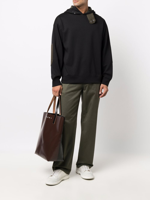
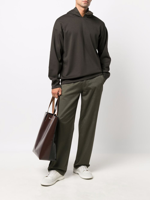
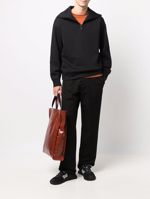
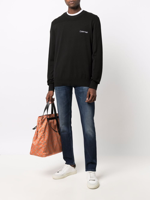
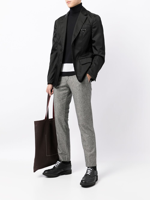
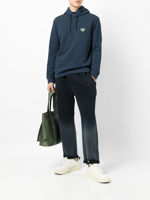
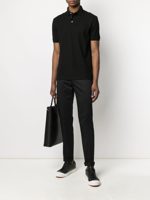
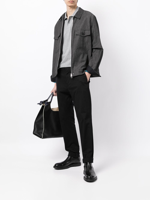
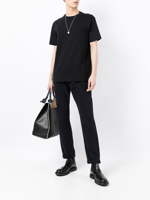
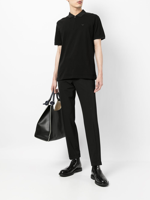
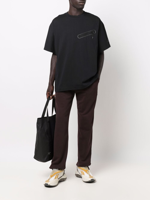
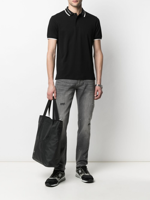
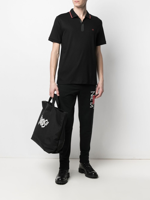
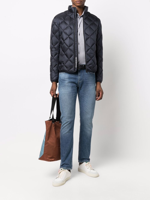
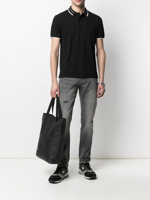
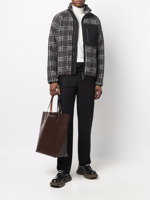
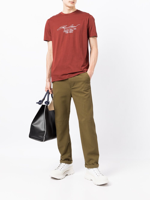
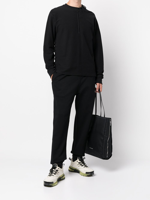
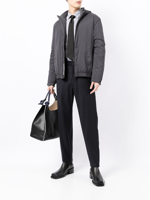
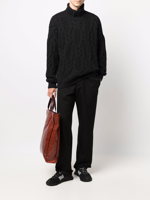


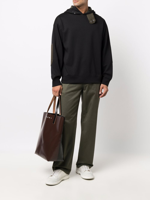
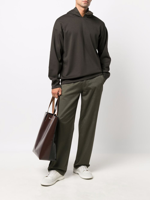
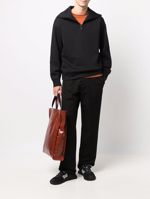
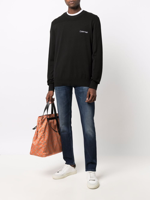
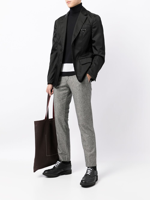
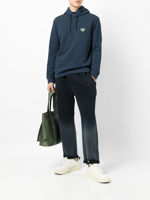
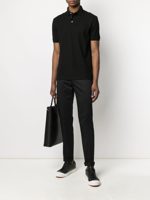
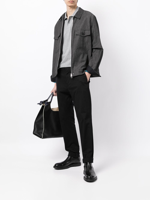
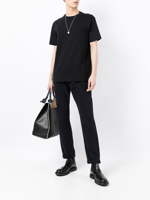
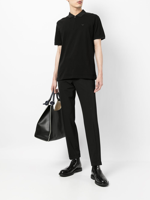
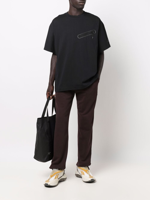
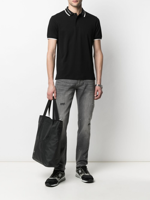
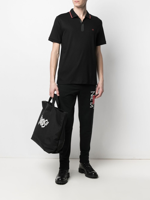
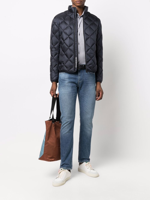
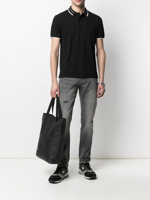
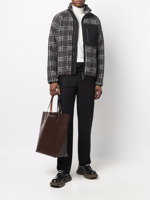
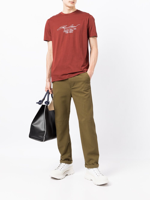
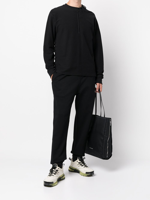
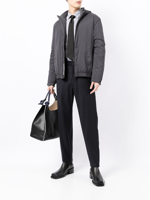
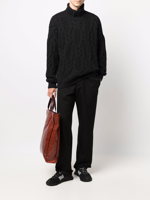

In [55]:
ipyplot.plot_images(images, labels, max_images=20, img_width=150)